In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open('Combined.json', 'r') as f:
    results_dict = json.load(f)


## Calculating lambda

In [10]:
def calculate_lambda(results_dict, function_name, direction, multiplier, target_p):
    """
    Calculates the ratio of logical error rates between distance 3 and 5 at target_p.
    Assumes target_p is present in the data set.
    """
    try:
        data = results_dict[function_name][direction][str(multiplier)]
    except KeyError as e:
        print(f"KeyError: {e}. Please check the input keys.")
        return None
    
    # Initialize variables to store logical error rates
    l5 = None
    l7 = None
    
    # Iterate through the data to find l3 and l5 at target_p
    for entry in data:
        n, p, l = entry
        if p == target_p:
            if n == 5:
                l5 = l
            elif n == 7:
                l7 = l
    
    # Check if both logical error rates were found
    if l5 is None:
        print(f"Logical error rate for distance 5 at P_phy = {target_p} not found.")
    if l7 is None:
        print(f"Logical error rate for distance 7 at P_phy = {target_p} not found.")
    
    if l5 is not None and l7 is not None:
        if l7 == 0:
            print("Logical error rate for distance 5 is zero. Cannot compute lambda.")
            return None
        lambda_ratio = l5 / l7
        print(f"At P_phy = {target_p}, Lambda (D=3/D=5) = {lambda_ratio}")
        return lambda_ratio
    else:
        print("Cannot compute lambda due to missing logical error rates.")
        return None


Example

In [ ]:
import os
import pandas as pd

# Define simulation parameters
function_names = ["Rotated_CAT", "Rotated_Direct", "Rotated_GT", "Unrotated_Direct", "unrotated_CAT", "unrotated_GT"]
directions = ["Horizontal", "Vertical"]
multipliers = [10, 1]
target_p = 0.0034362293368603814
lambda_results = []

# Loop over each simulation parameter combination
for func in function_names:
    for direc in directions:
        for mult in multipliers:
            print(f"Processing: Function = {func}, Direction = {direc}, Multiplier = {mult}")
            lambda_ratio = calculate_lambda(results_dict, func, direc, mult, target_p)
            lambda_results.append({
                "Function": func,
                "Direction": direc,
                "Multiplier": mult,
                "Target_p": target_p,
                "Lambda_Ratio (D=5/D=7)": lambda_ratio
            })

lambda_df = pd.DataFrame(lambda_results)
print("Lambda Ratio Summary:")
print(lambda_df)

# Save the DataFrame to a CSV file
csv_filename = "Full lambda - 0.00345.csv"
lambda_df.to_csv(csv_filename, index=False)
print(f"p Lambda results summary saved to {csv_filename}")

Processing: Function = Rotated_CAT, Direction = Horizontal, Multiplier = 10
At P_phy = 0.0034362293368603814, Lambda (D=3/D=5) = 1.4879087257972954
Processing: Function = Rotated_CAT, Direction = Horizontal, Multiplier = 1
At P_phy = 0.0034362293368603814, Lambda (D=3/D=5) = 1.5903150127744843
Processing: Function = Rotated_CAT, Direction = Vertical, Multiplier = 10
At P_phy = 0.0034362293368603814, Lambda (D=3/D=5) = 3.418367346938776
Processing: Function = Rotated_CAT, Direction = Vertical, Multiplier = 1
At P_phy = 0.0034362293368603814, Lambda (D=3/D=5) = 3.11587982832618
Processing: Function = Rotated_Direct, Direction = Horizontal, Multiplier = 10
At P_phy = 0.0034362293368603814, Lambda (D=3/D=5) = 1.6300074527903432
Processing: Function = Rotated_Direct, Direction = Horizontal, Multiplier = 1
At P_phy = 0.0034362293368603814, Lambda (D=3/D=5) = 1.8943308006599224
Processing: Function = Rotated_Direct, Direction = Vertical, Multiplier = 10
At P_phy = 0.0034362293368603814, Lambd

## Plotting two data sets simultaneously with threshold

Plotting function

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from collections import defaultdict
import matplotlib.ticker as mticker
from matplotlib import colors as mcolors

def find_intersection(p1, l1, p2, l2, tol=1e-9):
    """
    Find the intersection point of two curves defined by (p1, l1) and (p2, l2) in log-log scale.
    """
    # Convert inputs to numpy arrays if they aren't already
    p1, l1, p2, l2 = map(np.array, [p1, l1, p2, l2])
    
    # Check for non-positive values and filter them out
    if np.any(p1 <= 0) or np.any(l1 <= 0) or np.any(p2 <= 0) or np.any(l2 <= 0):
        print("Error: Non-positive values found in data. Log transformation is not possible.")
        return None

    # Transform to log scale
    log_p1 = np.log10(p1)
    log_l1 = np.log10(l1)
    log_p2 = np.log10(p2)
    log_l2 = np.log10(l2)



    # First check: Direct point matches
    for i, p in enumerate(log_p1):
        for j, p_other in enumerate(log_p2):
            if abs(p - p_other) < tol and abs(log_l1[i] - log_l2[j]) < tol:
                return 10**p  # Return back to original scale

    # Second check: Points where lines cross between discrete points
    for i in range(len(log_p1)-1):
        for j in range(len(log_p2)-1):
            # Define the line segments
            x1, y1 = log_p1[i], log_l1[i]
            x2, y2 = log_p1[i+1], log_l1[i+1]
            x3, y3 = log_p2[j], log_l2[j]
            x4, y4 = log_p2[j+1], log_l2[j+1]
            
            # Calculate denominator for intersection check
            denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
            
            if abs(denom) > tol:  # Lines aren't parallel
                t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / denom
                u = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / denom
                
                # Check if intersection occurs within both line segments
                if 0 <= t <= 1 and 0 <= u <= 1:
                    # Calculate intersection point
                    p_int = x1 + t * (x2 - x1)
                    return 10**p_int  # Return back to original scale

    # If no intersection found in discrete points or line segments,
    # fall back to interpolation method
    try:
        # Create interpolation functions
        interp1 = interp1d(log_p1, log_l1, kind='cubic', fill_value="extrapolate")
        interp2 = interp1d(log_p2, log_l2, kind='cubic', fill_value="extrapolate")
        
        # Define a range for p where both interpolations are valid
        p_min = max(min(log_p1), min(log_p2))
        p_max = min(max(log_p1), max(log_p2))
        
        # Define the function for root finding
        def func(p):
            return interp1(p) - interp2(p)
        
        # Use brentq to find the root where func(p) = 0
        p_threshold = brentq(func, p_min, p_max)
        
        # Verify the intersection point is reasonable
        l_threshold = 10**interp1(p_threshold)  # Convert back to original scale
        if l_threshold < 0:  # Physical check for logical error rates
            return None
            
        return 10**p_threshold  # Return back to original scale
    except (ValueError, RuntimeError) as e:
        print(f"Error finding intersection: {e}")
        return None
def plot_two_simulation_results(
    results_dict,
    function_name1,
    direction1,
    multiplier1,
    function_name2=None,
    direction2=None,
    multiplier2=None,
    save_path=None  # Path to save the plot PNG
):
    """
    Plots two simulation results on the same log-log plot.
    Uses the same color for each distance in both data sets.
    One data set is dimmed while the other is in full color.
    Adds a dashed magenta vertical line at the threshold where d=3 and d=7 curves intersect.
    If no intersection is found between d=3 and d=7, it attempts to find an intersection between d=3 and d=5.
    Adds a horizontal arrow indicating the shift between thresholds.
    Includes numerical threshold values in the legend (up to 3 significant digits).
    
    Parameters:
    - results_dict (dict): Nested dictionary containing simulation results.
    - function_name1 (str): Name of the first function (e.g., "Rotated_CAT").
    - direction1 (str): Direction of the first data set ("Vertical" or "Horizontal").
    - multiplier1 (float): Multiplier for the first data set.
    - function_name2 (str): Name of the second function.
    - direction2 (str): Direction of the second data set.
    - multiplier2 (float): Multiplier for the second data set.
    - save_path (str, optional): Path to save the plot PNG. Defaults to None.
    
    Returns:
    - None: Displays and optionally saves the plot.
    """
    # Define a color mapping for distances
    color_map = {
        '3': 'blue',
        '5': 'orange',
        '7': 'green',
        '9': 'red',
        '11': 'purple'
    }
    color_map = {key: color for key, color in zip(color_map.keys(), mcolors.TABLEAU_COLORS.values())}

    marker_map = {
        '3': '^',   # Triangle
        '5': 'D',   # Diamond
        '7': 'o',   # Circle
        '9': 's',   # Square
        '11': 'x'   # Cross
        }
    # -------------------------------------------------------------------------
    # 1) HELPER: ORGANIZE, CLEAN, AND SORT DATA
    # -------------------------------------------------------------------------
    def get_sorted_data(fn, dir, mult):
        try:
            data = results_dict[fn][dir][str(mult)]
        except KeyError as e:
            print(f"KeyError for {fn}, {dir}, {mult}: {e}")
            return None
        
        data_by_distance = {}
        for entry in data:
            if len(entry) != 3:
                print(f"Invalid entry format: {entry}. Expected (n, p, l). Skipping.")
                continue
            n, p, l_val = entry
            n_str = str(n)
            if n_str not in data_by_distance:
                data_by_distance[n_str] = {'p': [], 'l': []}
            data_by_distance[n_str]['p'].append(p)
            data_by_distance[n_str]['l'].append(l_val)
        
        # Sort p and l for each distance and apply cleaning rules
        for dist_str in data_by_distance:
            p_arr = np.array(data_by_distance[dist_str]['p'])
            l_arr = np.array(data_by_distance[dist_str]['l'])
            idx_sort = np.argsort(p_arr)
            
            p_sorted = p_arr[idx_sort]
            l_sorted = l_arr[idx_sort]
            
            # Omit the first three points based on your conditions
            points_to_keep = []
            for i in range(len(p_sorted)):
                if i < 3:
                    if l_sorted[i] == 0:
                        continue  # Omit point
                    if i < len(p_sorted) - 1 and l_sorted[i] > l_sorted[i+1]:
                        continue  # Omit point
                points_to_keep.append(i)
            
            if not points_to_keep:
                print(f"All points omitted for distance {dist_str}.")
                data_by_distance[dist_str]['p'] = np.array([])
                data_by_distance[dist_str]['l'] = np.array([])
                continue
            
            data_by_distance[dist_str]['p'] = p_sorted[points_to_keep]
            data_by_distance[dist_str]['l'] = l_sorted[points_to_keep]
        
        return data_by_distance

    # -------------------------------------------------------------------------
    # 2) COMPUTE THRESHOLD BY FINDING INTERSECTION BETWEEN d=3 AND d=7
    #    IF NOT FOUND, THEN BETWEEN d=3 AND d=5
    # -------------------------------------------------------------------------
    from itertools import combinations
    from collections import Counter

    def compute_threshold(data_dict):
        """
        Compute the threshold by aggregating intersections between consecutive pairs of distance curves.
        """
        # Extract available distances and sort them numerically
        try:
            distances = sorted([int(d) for d in data_dict.keys()])
        except ValueError as e:
            print(f"Invalid distance key found: {e}")
            return None

        intersections = []
        averages = []
        
        # Iterate over consecutive pairs of distances
        for i in range(len(distances) - 1):
            d1, d2 = distances[i], distances[i + 1]
            key1, key2 = str(d1), str(d2)
            try:
                p1, l1 = data_dict[key1]['p'], data_dict[key1]['l']
                p2, l2 = data_dict[key2]['p'], data_dict[key2]['l']
            except KeyError as e:
                print(f"Missing data for distances d={d1} or d={d2}: {e}")
                continue  # Skip to the next pair
            
            # Ensure there are enough data points to compute intersection
            if len(p1) >= 2 and len(p2) >= 2:
                p_threshold = find_intersection(p1, l1, p2, l2)
                if p_threshold is not None and p_threshold != 0:
                    print(f"Found intersection between d={d1} and d={d2}: {p_threshold}")
                    intersections.append(p_threshold)
                    averages.append((d1 + d2) / 2)  # Calculate average of distances
                else:
                    print(f"No valid intersection found between d={d1} and d={d2}.")
            else:
                print(f"Insufficient data points for d={d1} or d={d2}.")

        if not intersections:
            print("No valid intersections found across all consecutive distance pairs.")
            return None

        # Plot the intersection points against the average distances
        plt.figure(figsize=(10, 6))
        plt.scatter(averages, intersections, color='blue', label='Intersections')
        plt.xlabel('Average Distance')
        plt.yscale('log')

        plt.ylabel('Intersection Point (Logical Error Rate)')
        plt.title('Intersection Points vs Average Distance')
        plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Add a horizontal line at y=0
        plt.legend()
        plt.grid()
        plt.show()

        # Calculate the average of the found intersections
        average_threshold = sum(intersections) / len(intersections)
        print(f"Average of valid intersections: {average_threshold}")
        return average_threshold    # 3) PROCESS AND DETECT THRESHOLDS FOR BOTH DATA SETS
    # -------------------------------------------------------------------------
    data1 = get_sorted_data(function_name1, direction1, multiplier1)
    if multiplier2 is not None:
        data2 = get_sorted_data(function_name2, direction2, multiplier2)
    else:
        data2 = None

    if data1 is None or data2 is None:
        print("One or both data sets could not be retrieved. Exiting.")

    # Compute thresholds for both data sets
    p_threshold1 = compute_threshold(data1)
    if p_threshold1 is not None:
        print(f"Threshold p for set1 ({function_name1} γ={multiplier1}): {p_threshold1:.6f}")
    else:
        print(f"No valid threshold found for set1 ({function_name1} γ={multiplier1}).")

    if data2 is not None:
        p_threshold2 = compute_threshold(data2)
        if p_threshold2 is not None:
            print(f"Threshold p for set2 ({function_name2} γ={multiplier2}): {p_threshold2:.6f}")
        else:
            print(f"No valid threshold found for set2 ({function_name2} γ={multiplier2}).")
    else:
        p_threshold2 = None
        print(f"No set2 data found for {function_name2} γ={multiplier2}.")

    # -------------------------------------------------------------------------
    # 4) PLOT
    # -------------------------------------------------------------------------
    direction_label1 = "Across" if direction1 == "Horizontal" else "Parallel"
    direction_label2 = "Across" if direction2 == "Horizontal" else "Parallel"

    # Font sizes
    title_fontsize = 20
    label_fontsize = 18
    tick_fontsize = 18
    legend_fontsize = 18
    grid_linewidth = 0.5
    grid_linestyle = '-.'

    plt.figure(figsize=(12, 8))

    # Plot first data set (full color)
    for dist_str, values in data1.items():
        if len(values['p']) == 0:
            print(f"No data to plot for distance {dist_str} in set1.")
            continue
        color = color_map.get(dist_str, 'black')
        marker = marker_map.get(dist_str, 'o')
        plt.plot(
            values['p'],
            values['l'],
            marker=marker,
            markersize=7, 

            linestyle='-',
            linewidth=2,
            color=color,
            label=f'd = {dist_str}, γ={multiplier1}  '
        )

    # Plot second data set (dimmed)
    if data2 is not None:

        for dist_str, values in data2.items():
            if len(values['p']) == 0:
                print(f"No data to plot for distance {dist_str} in set2.")
                continue
            color = color_map.get(dist_str, 'black')
            marker = marker_map.get(dist_str, 'o')
            plt.plot(
                values['p'],
                values['l'],
                marker=marker,
                markersize=7, 
                linestyle=':',
                linewidth=2,
                color=color,
                alpha=1,
                label=f'd = {dist_str}, γ={multiplier2}'
            )

    # Threshold lines
    if p_threshold1 is not None:
        plt.axvline(
            x=p_threshold1,
            color='magenta',
            linestyle='solid',
            linewidth=2,
            label=f'$p_{{th}}$ $\gamma= 10$: {p_threshold1*100:.3f}%',
            alpha=1.0
        )
    if p_threshold2 is not None:
        plt.axvline(
            x=p_threshold2,
            color='black',
            linestyle='-.',
            linewidth=2,
            label=f'$p_{{th}}$ $\gamma= 1$: {p_threshold2*100:.3f}%',
            alpha=0.8
        )

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Physical Error Rate $P_{phy}$', fontsize=label_fontsize)
    plt.ylabel('Logical Error Rate $P_{log}$', fontsize=label_fontsize)
    if multiplier2 is not None:
        plt.title(''
        )
    else:
        plt.title('')  
    
    plt.legend(fontsize=legend_fontsize)
    plt.grid(True, which="both", ls=grid_linestyle, linewidth=grid_linewidth)
    
    # Tick label font sizes
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    
    # Horizontal arrow if both thresholds exist
    if p_threshold1 is not None and p_threshold2 is not None:
        if p_threshold2 < p_threshold1:
            start_p = p_threshold2
            end_p = p_threshold1
        else:
            start_p = p_threshold2
            end_p = p_threshold1
        
        y_min, y_max = plt.ylim()
        y_arrow = y_min * 1.30  # Position the arrow slightly above the minimum y-value
        
        plt.annotate(
            '',
            xy=(end_p, y_arrow),
            xytext=(start_p, y_arrow),
            arrowprops=dict(
                arrowstyle='->',
                color='magenta',
                linewidth=2,
                shrinkA=0,
                shrinkB=0
            ),
            annotation_clip=False
        )

    if save_path:
        # Make sure the figure is vector-based
        plt.rcParams['pdf.fonttype'] = 42  # Ensures TrueType fonts are used
        plt.rcParams['ps.fonttype'] = 42   # Ensures TrueType fonts in PostScript
        plt.rcParams['svg.fonttype'] = 'none'  # Ensures text remains as text in SVG
        
        # Save as vector PDF
        plt.savefig(
            save_path,
            format='pdf',
            dpi=300,
            bbox_inches='tight',
            metadata={'Creator': '', 'Producer': ''},
            backend='pdf',  # Explicitly use PDF backend
        )
        print(f"Plot saved to {save_path}")

    plt.show()
    return p_threshold1,p_threshold2

Mass Processing

Generating plot for Function: Rotated_CAT, Direction: Horizontal
Found intersection between d=3 and d=5: 0.005135388275532497
Found intersection between d=5 and d=7: 0.0056158319092437705
Found intersection between d=7 and d=9: 0.005810072135492507
Found intersection between d=9 and d=11: 0.006293823325983284


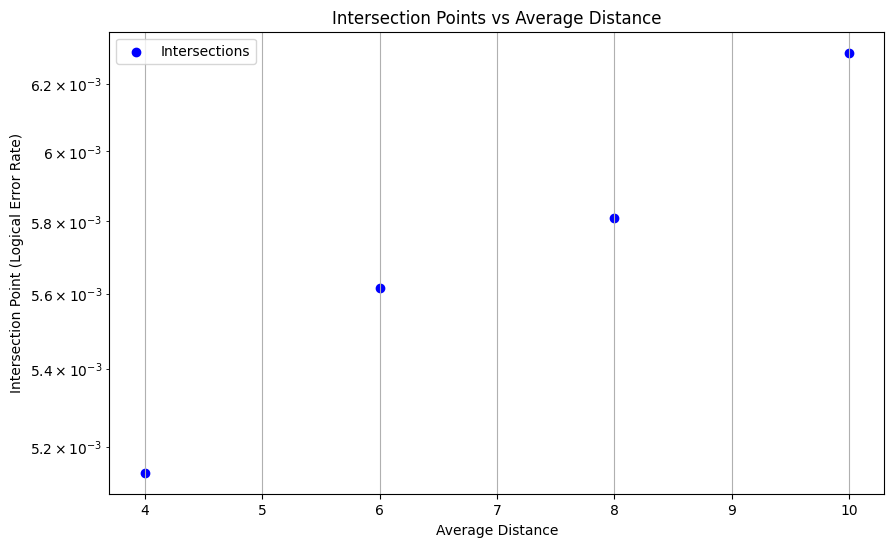

Average of valid intersections: 0.005713778911563015
Threshold p for set1 (Rotated_CAT γ=10): 0.005714
Found intersection between d=3 and d=5: 0.005326150202307401
Found intersection between d=5 and d=7: 0.006114069590043121
Found intersection between d=7 and d=9: 0.00609578990285813
Found intersection between d=9 and d=11: 0.00611850164758868


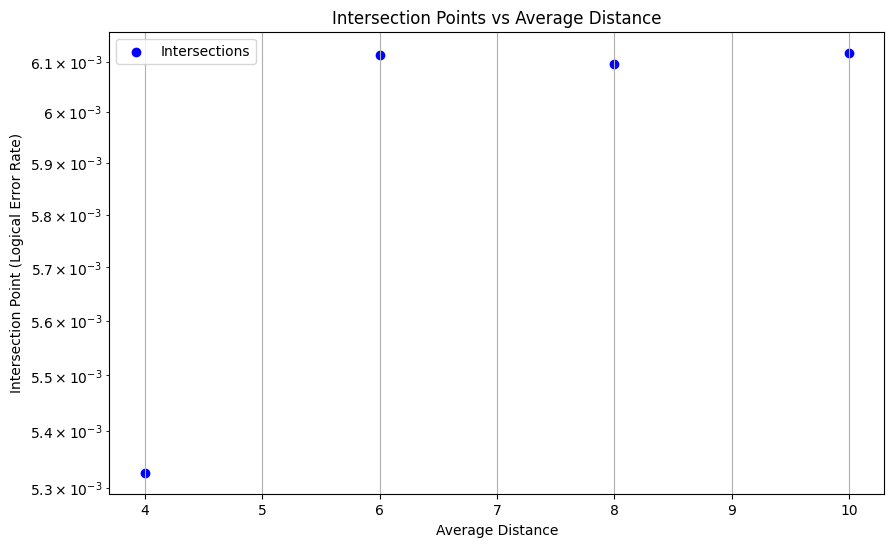

Average of valid intersections: 0.005913627835699333
Threshold p for set2 (Rotated_CAT γ=1): 0.005914
Plot saved to [[27FEB]] - [[PDF]] FULL+IDLING- EXTRA DISTANCES\Rotated_CAT_Horizontal_gamma10_gamma1.PDF


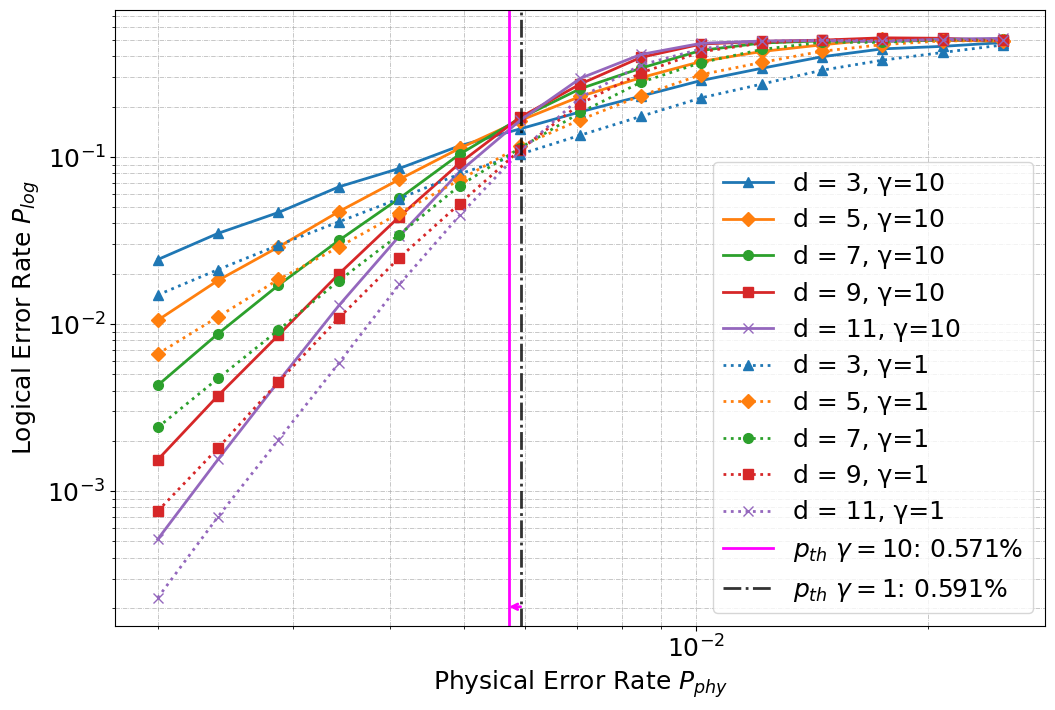

Generating plot for Function: Rotated_CAT, Direction: Vertical
Found intersection between d=3 and d=5: 0.00661767522002705
Found intersection between d=5 and d=7: 0.006498073758255918
Found intersection between d=7 and d=9: 0.00640191315543869
Found intersection between d=9 and d=11: 0.006456577563431812


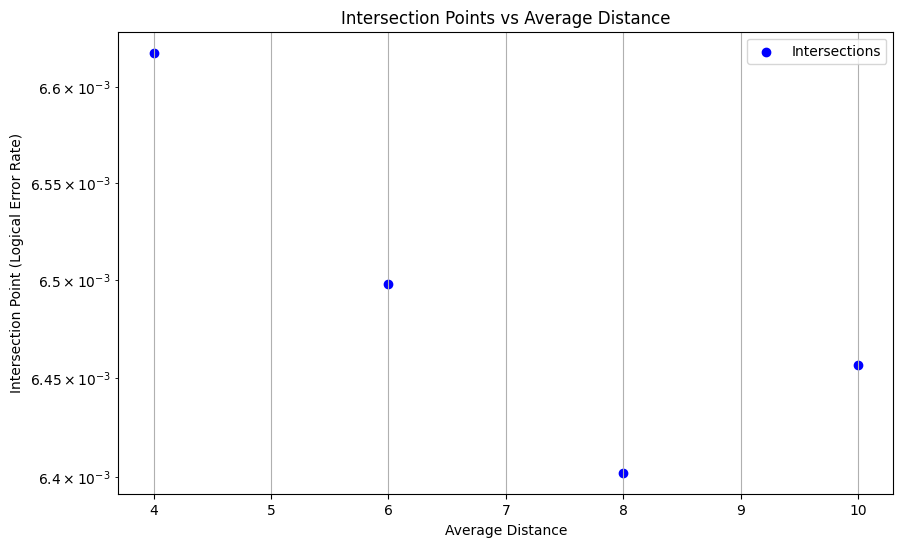

Average of valid intersections: 0.0064935599242883675
Threshold p for set1 (Rotated_CAT γ=10): 0.006494
Found intersection between d=3 and d=5: 0.006704961649183946
Found intersection between d=5 and d=7: 0.006622636655541167
Found intersection between d=7 and d=9: 0.0065362523793009025
Found intersection between d=9 and d=11: 0.006339760313738065


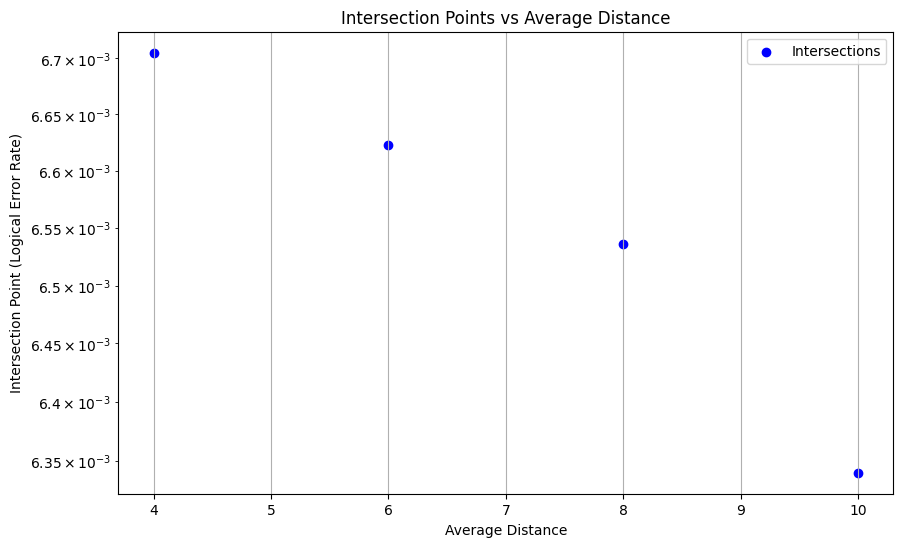

Average of valid intersections: 0.0065509027494410205
Threshold p for set2 (Rotated_CAT γ=1): 0.006551
Plot saved to [[27FEB]] - [[PDF]] FULL+IDLING- EXTRA DISTANCES\Rotated_CAT_Vertical_gamma10_gamma1.PDF


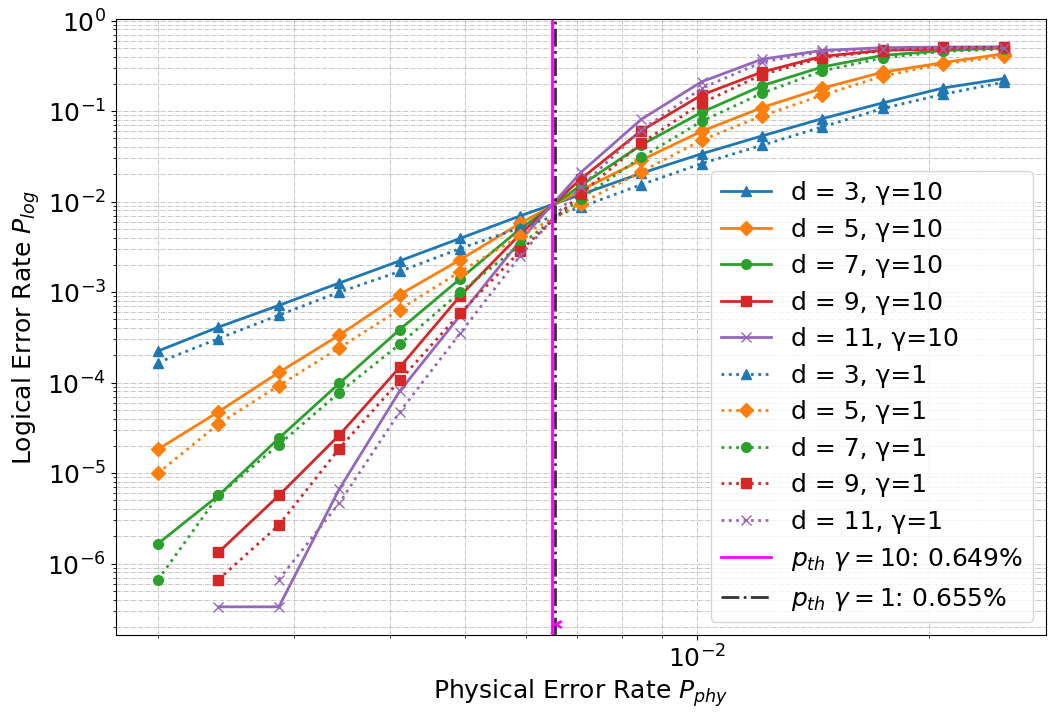

Generating plot for Function: Rotated_Direct, Direction: Horizontal
Found intersection between d=3 and d=5: 0.005249221008507875
Found intersection between d=5 and d=7: 0.0063214699746172495
Found intersection between d=7 and d=9: 0.006582357011355879
Found intersection between d=9 and d=11: 0.007077354225374239


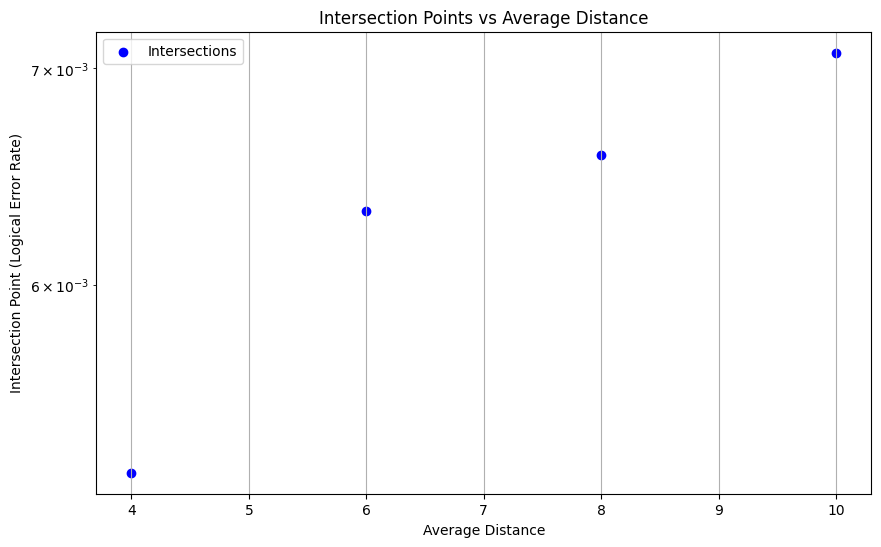

Average of valid intersections: 0.006307600554963811
Threshold p for set1 (Rotated_Direct γ=10): 0.006308
Found intersection between d=3 and d=5: 0.006001412149182732
Found intersection between d=5 and d=7: 0.006745181133171723
Found intersection between d=7 and d=9: 0.007337050799562027
Found intersection between d=9 and d=11: 0.0070439403675304265


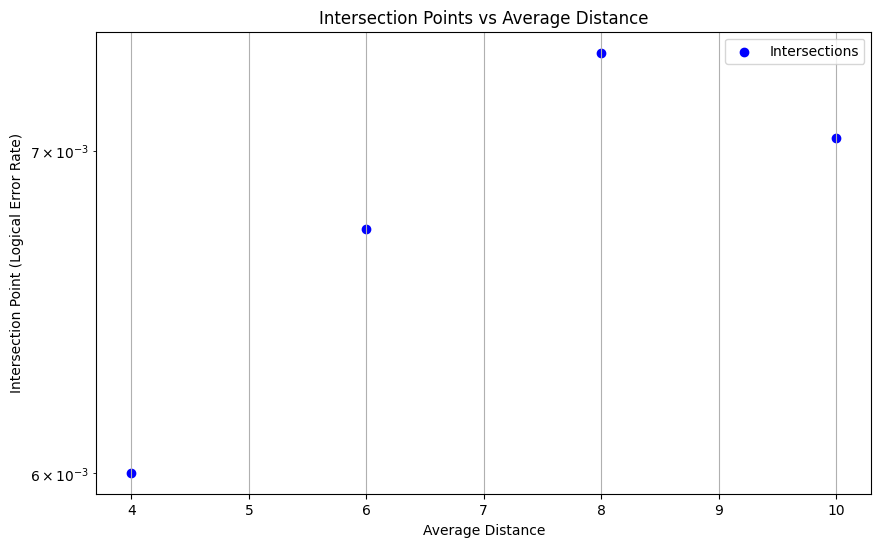

Average of valid intersections: 0.006781896112361728
Threshold p for set2 (Rotated_Direct γ=1): 0.006782
Plot saved to [[27FEB]] - [[PDF]] FULL+IDLING- EXTRA DISTANCES\Rotated_Direct_Horizontal_gamma10_gamma1.PDF


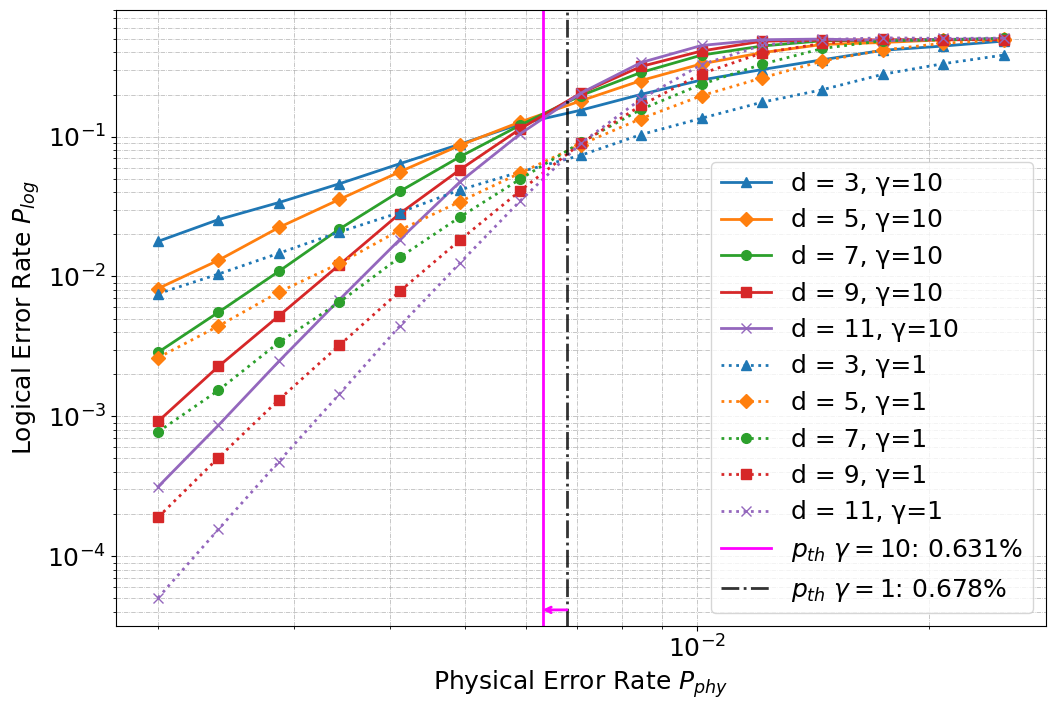

Generating plot for Function: Rotated_Direct, Direction: Vertical
Found intersection between d=3 and d=5: 0.00798668703362021
Found intersection between d=5 and d=7: 0.007761997591226606
Found intersection between d=7 and d=9: 0.0076511047436140164
Error: Non-positive values found in data. Log transformation is not possible.
No valid intersection found between d=9 and d=11.


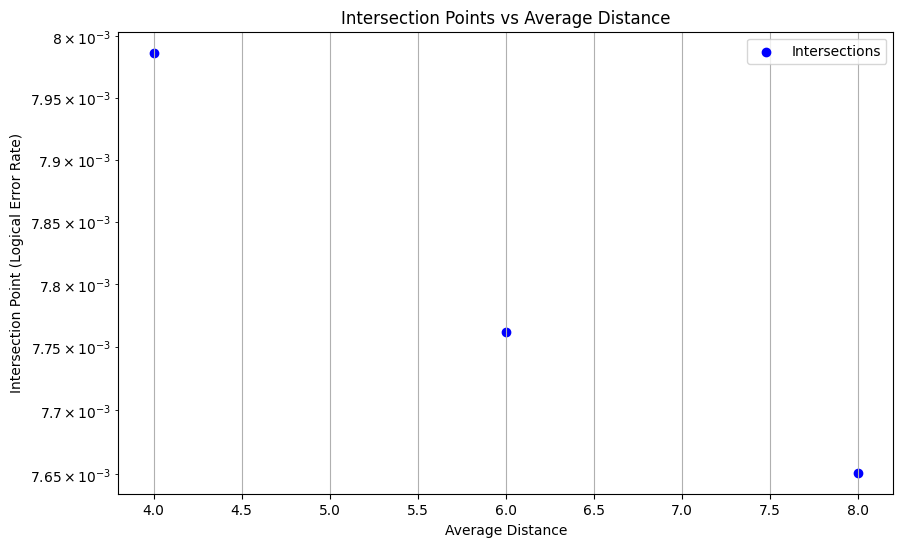

Average of valid intersections: 0.007799929789486944
Threshold p for set1 (Rotated_Direct γ=10): 0.007800
Found intersection between d=3 and d=5: 0.008193256518132313
Found intersection between d=5 and d=7: 0.007631410010036893
Found intersection between d=7 and d=9: 0.00792963608188558
Found intersection between d=9 and d=11: 0.007570970422247228


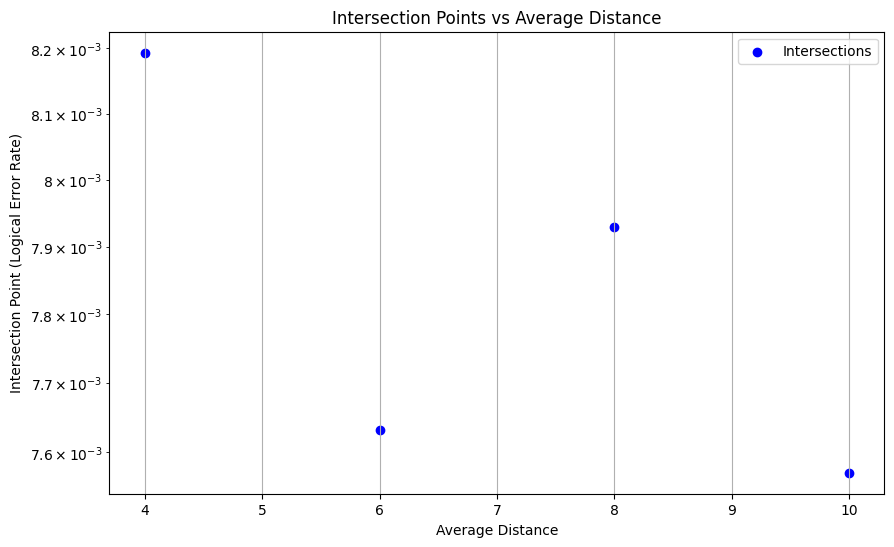

Average of valid intersections: 0.007831318258075502
Threshold p for set2 (Rotated_Direct γ=1): 0.007831
Plot saved to [[27FEB]] - [[PDF]] FULL+IDLING- EXTRA DISTANCES\Rotated_Direct_Vertical_gamma10_gamma1.PDF


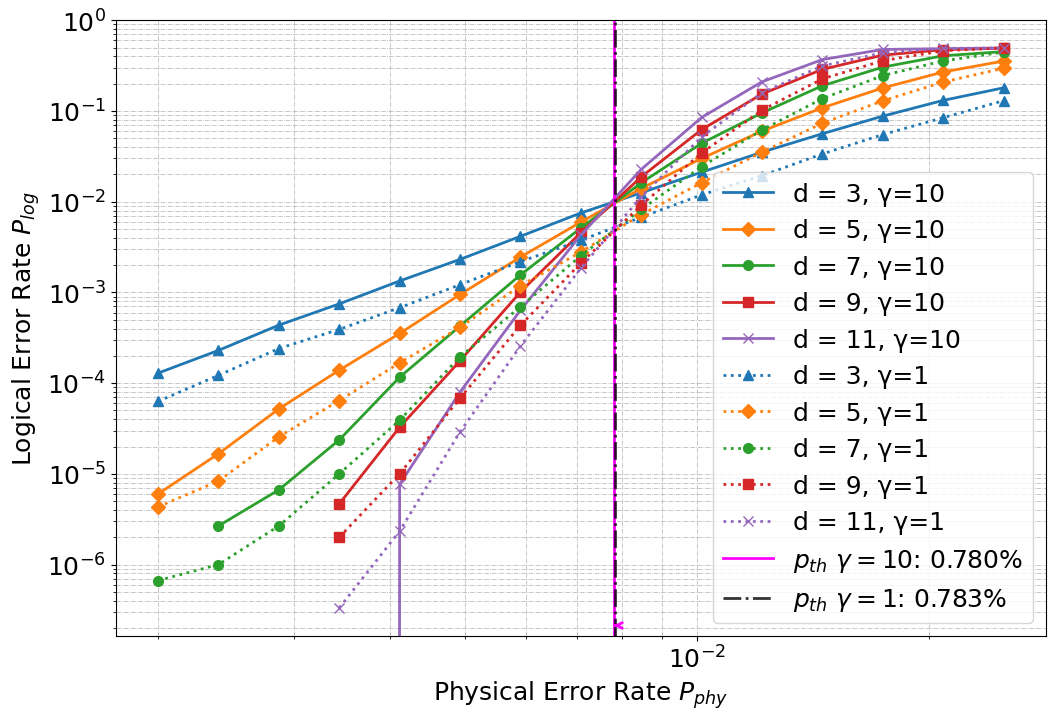

Generating plot for Function: Rotated_GT, Direction: Horizontal
Found intersection between d=3 and d=5: 0.004907745550248419
Found intersection between d=5 and d=7: 0.005493989758595964
Found intersection between d=7 and d=9: 0.005698414879497347
Found intersection between d=9 and d=11: 0.005789771522498165


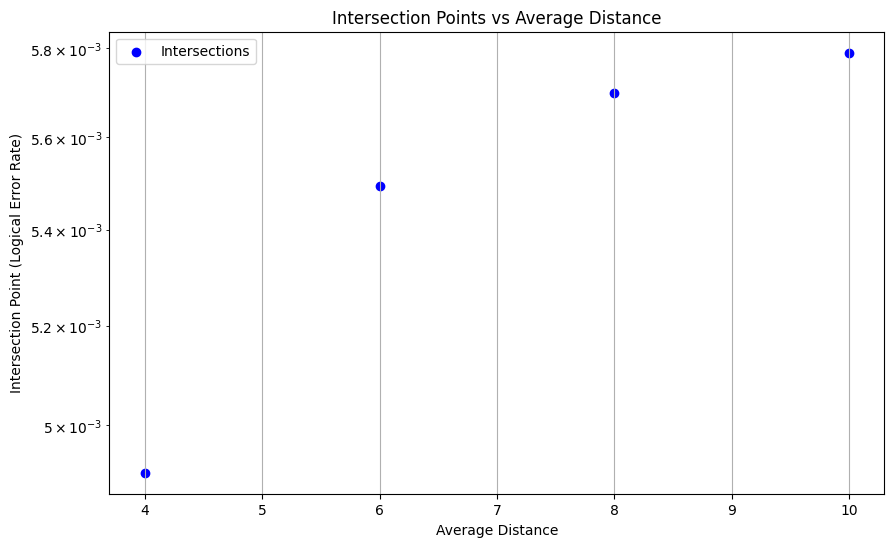

Average of valid intersections: 0.005472480427709974
Threshold p for set1 (Rotated_GT γ=10): 0.005472
Found intersection between d=3 and d=5: 0.005227743219596018
Found intersection between d=5 and d=7: 0.005892344551335294
Found intersection between d=7 and d=9: 0.006094632362472105
Found intersection between d=9 and d=11: 0.0062989791605467995


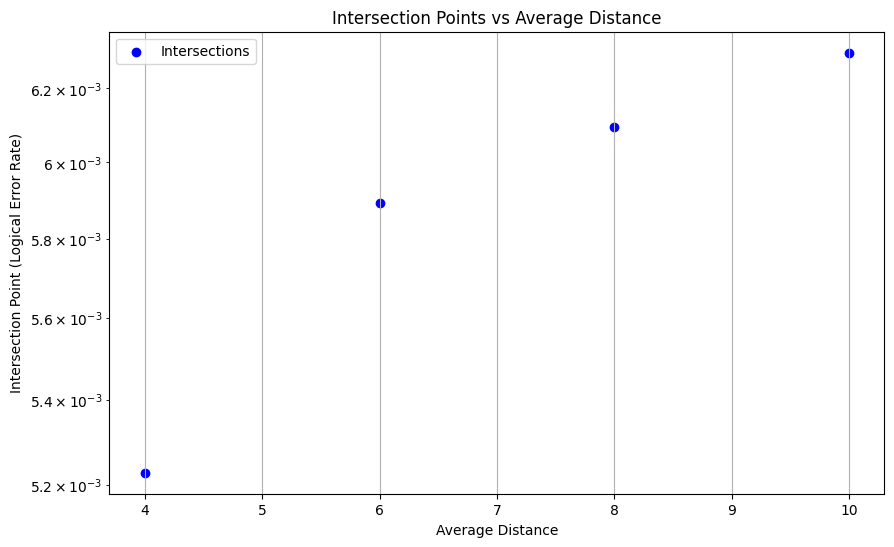

Average of valid intersections: 0.005878424823487554
Threshold p for set2 (Rotated_GT γ=1): 0.005878
Plot saved to [[27FEB]] - [[PDF]] FULL+IDLING- EXTRA DISTANCES\Rotated_GT_Horizontal_gamma10_gamma1.PDF


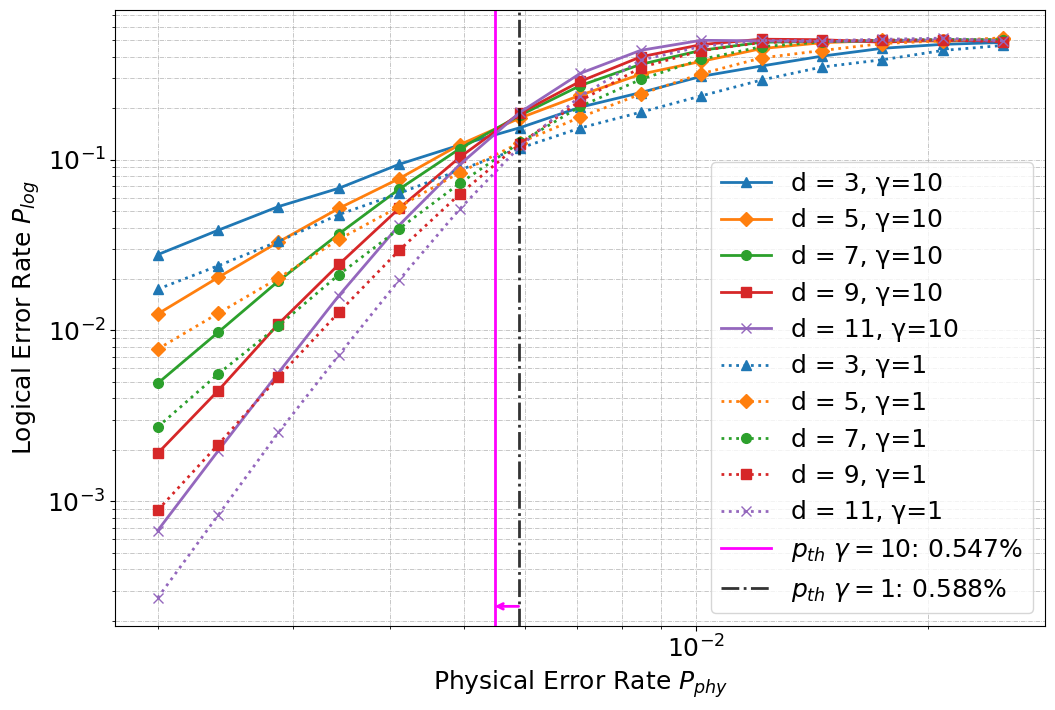

Generating plot for Function: Rotated_GT, Direction: Vertical
Found intersection between d=3 and d=5: 0.0066462211504251115
Found intersection between d=5 and d=7: 0.0063565707726290594
Found intersection between d=7 and d=9: 0.0064489462740289745
Found intersection between d=9 and d=11: 0.006193533020361294


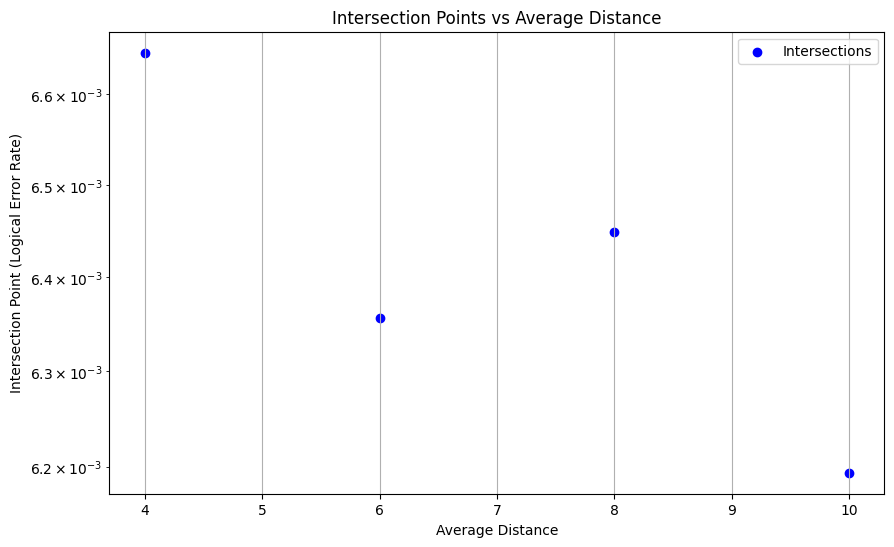

Average of valid intersections: 0.0064113178043611095
Threshold p for set1 (Rotated_GT γ=10): 0.006411
Found intersection between d=3 and d=5: 0.0066811700874105685
Found intersection between d=5 and d=7: 0.006506220937069505
Found intersection between d=7 and d=9: 0.006513692431197209
Found intersection between d=9 and d=11: 0.0064478087767483915


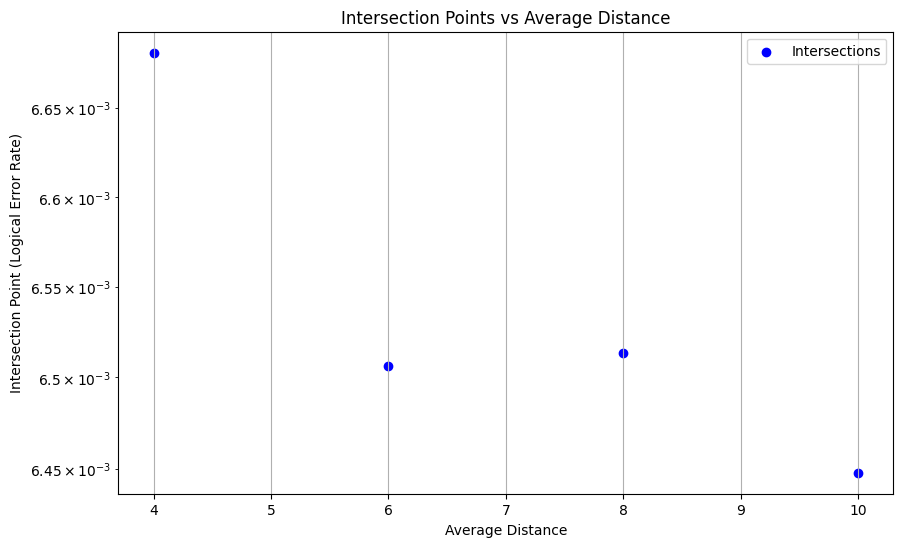

Average of valid intersections: 0.006537223058106418
Threshold p for set2 (Rotated_GT γ=1): 0.006537
Plot saved to [[27FEB]] - [[PDF]] FULL+IDLING- EXTRA DISTANCES\Rotated_GT_Vertical_gamma10_gamma1.PDF


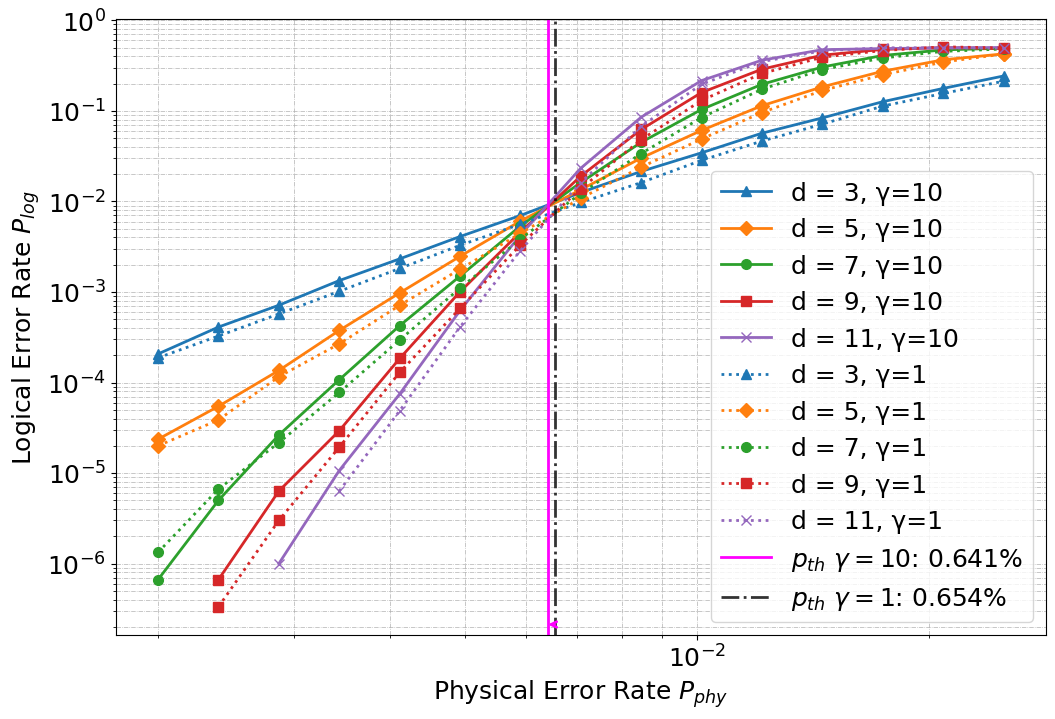

Generating plot for Function: Unrotated_Direct, Direction: Horizontal
Found intersection between d=3 and d=5: 0.007502805448892442
Found intersection between d=5 and d=7: 0.007193097887910247
Found intersection between d=7 and d=9: 0.007276934686956279
Found intersection between d=9 and d=11: 0.007293574237510297


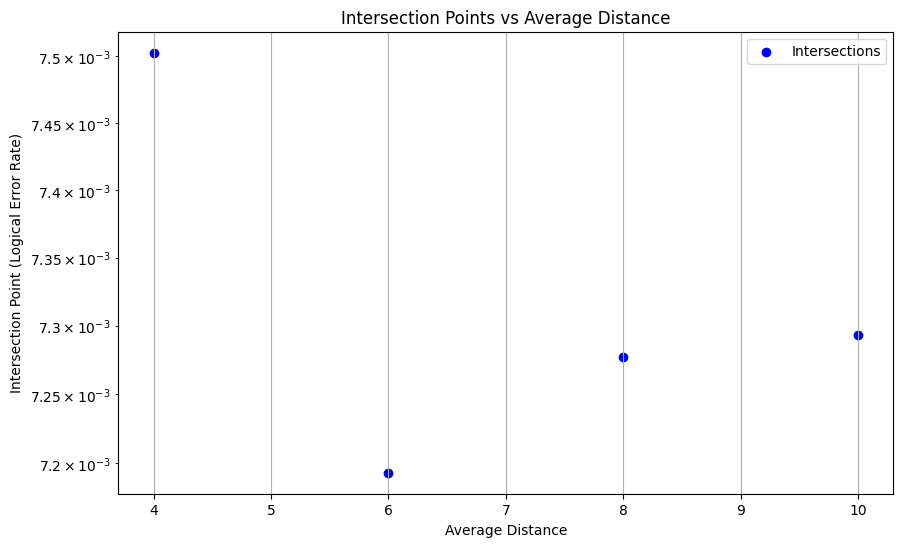

Average of valid intersections: 0.007316603065317316
Threshold p for set1 (Unrotated_Direct γ=10): 0.007317
Found intersection between d=3 and d=5: 0.008012723519976383
Found intersection between d=5 and d=7: 0.007456561853402295
Found intersection between d=7 and d=9: 0.0075242558059450725
Found intersection between d=9 and d=11: 0.007728714887470945


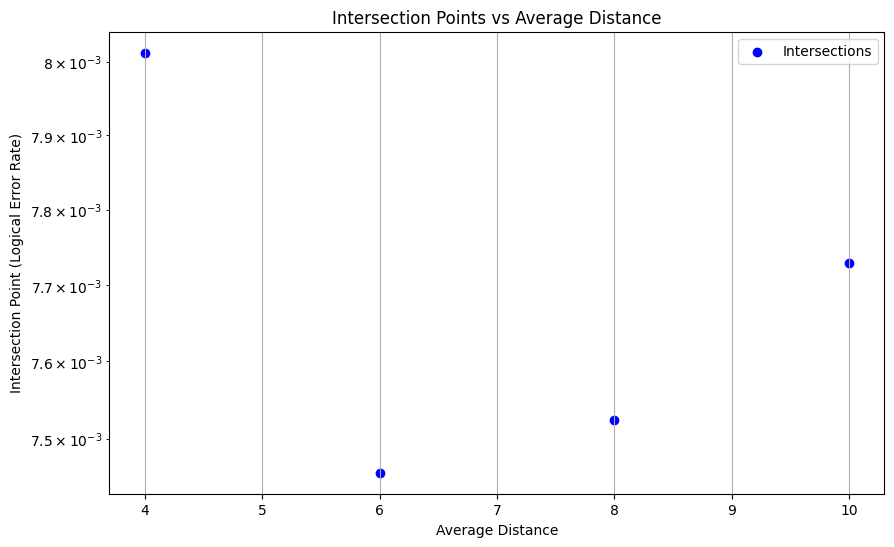

Average of valid intersections: 0.007680564016698674
Threshold p for set2 (Unrotated_Direct γ=1): 0.007681
Plot saved to [[27FEB]] - [[PDF]] FULL+IDLING- EXTRA DISTANCES\Unrotated_Direct_Horizontal_gamma10_gamma1.PDF


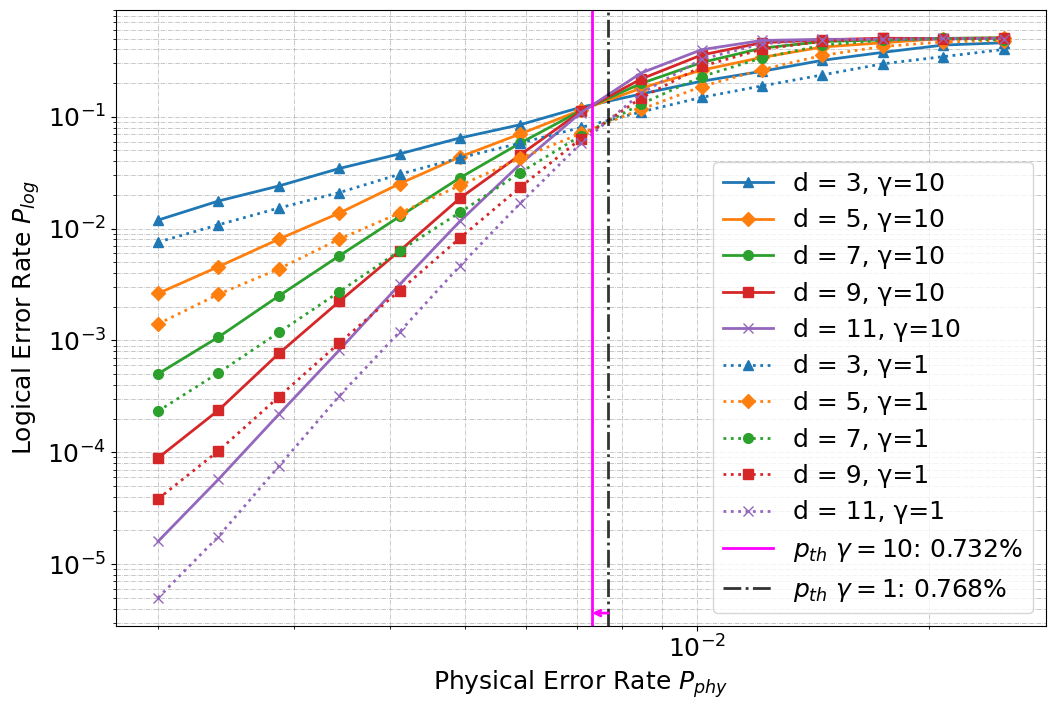

Generating plot for Function: Unrotated_Direct, Direction: Vertical
Found intersection between d=3 and d=5: 0.007812246923479991
Found intersection between d=5 and d=7: 0.007683687426107661
Found intersection between d=7 and d=9: 0.0075315851585513235
Error: Non-positive values found in data. Log transformation is not possible.
No valid intersection found between d=9 and d=11.


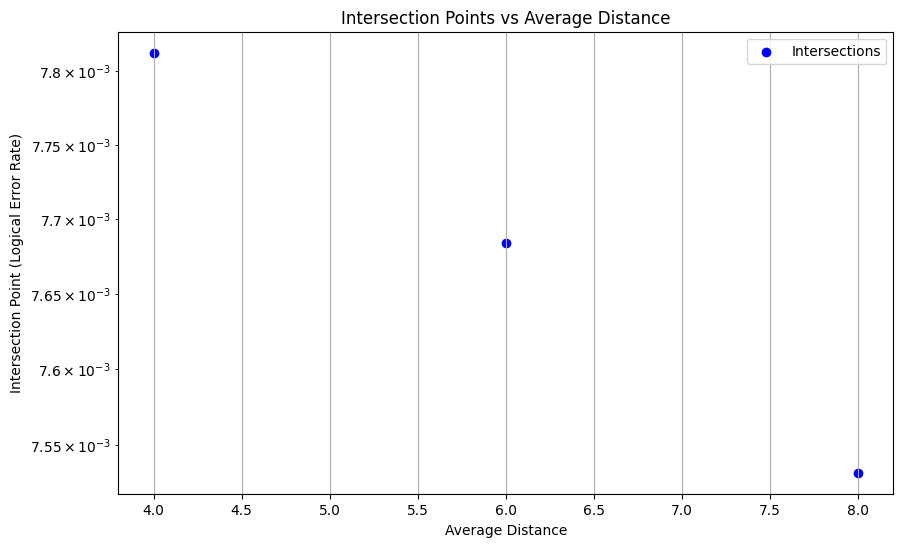

Average of valid intersections: 0.007675839836046326
Threshold p for set1 (Unrotated_Direct γ=10): 0.007676
Found intersection between d=3 and d=5: 0.00785036794957721
Found intersection between d=5 and d=7: 0.007540880582786233
Found intersection between d=7 and d=9: 0.007602746422708332
Found intersection between d=9 and d=11: 0.007597925361849523


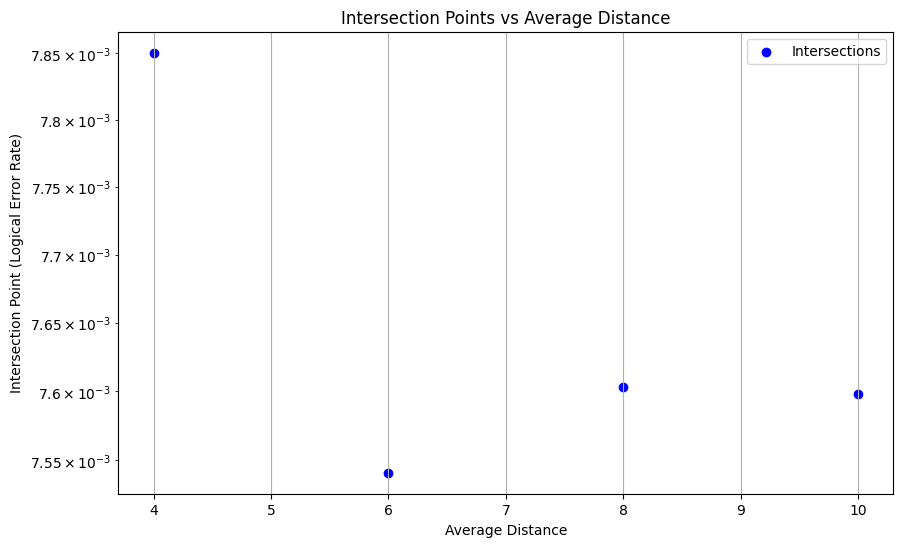

Average of valid intersections: 0.007647980079230324
Threshold p for set2 (Unrotated_Direct γ=1): 0.007648
Plot saved to [[27FEB]] - [[PDF]] FULL+IDLING- EXTRA DISTANCES\Unrotated_Direct_Vertical_gamma10_gamma1.PDF


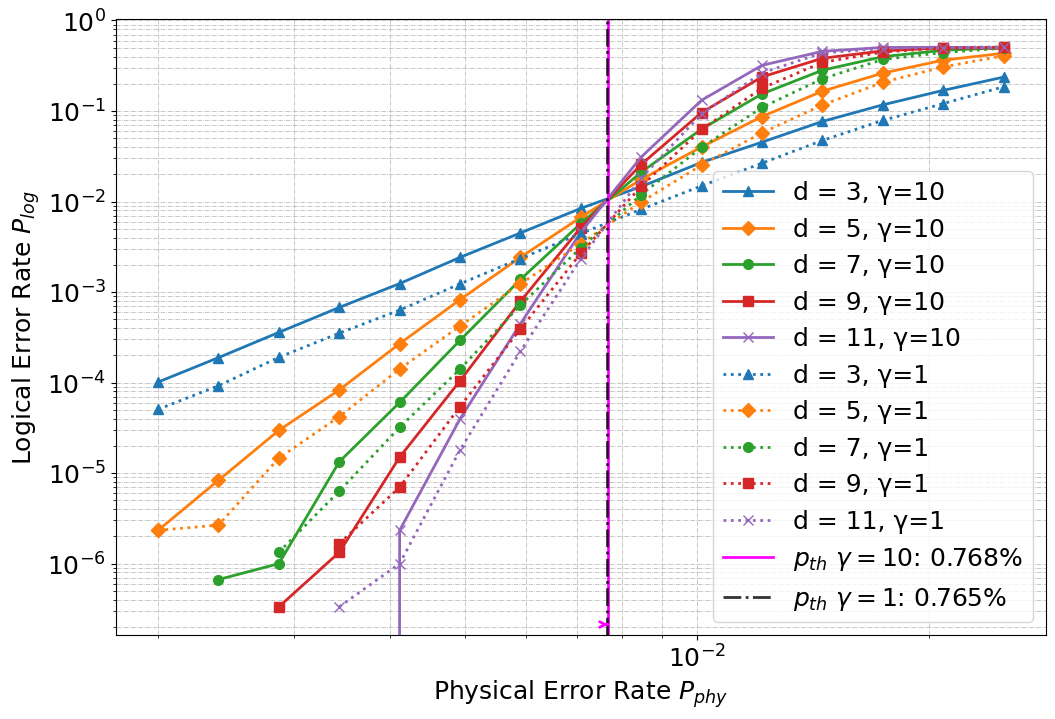

Generating plot for Function: unrotated_CAT, Direction: Horizontal
Found intersection between d=3 and d=5: 0.00580432029362413
Found intersection between d=5 and d=7: 0.006176620020207878
Found intersection between d=7 and d=9: 0.00586800975781598
Found intersection between d=9 and d=11: 0.006254437888823899


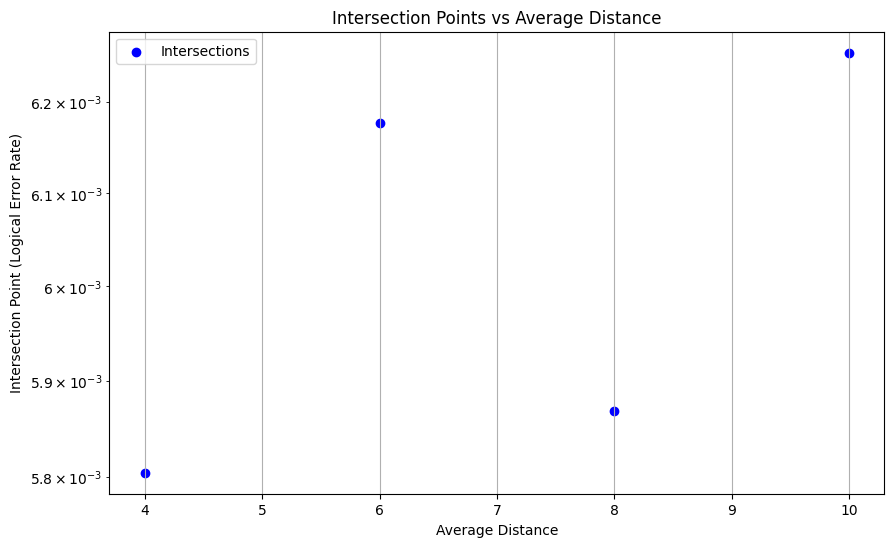

Average of valid intersections: 0.006025846990117972
Threshold p for set1 (unrotated_CAT γ=10): 0.006026
Found intersection between d=3 and d=5: 0.006324378948404028
Found intersection between d=5 and d=7: 0.0062698012305994495
Found intersection between d=7 and d=9: 0.006337102653811195
Found intersection between d=9 and d=11: 0.006351630159166397


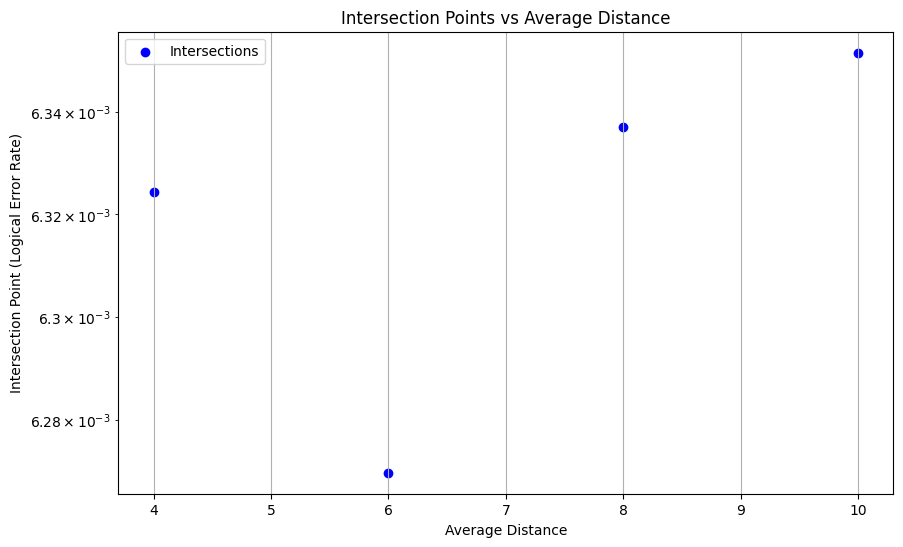

Average of valid intersections: 0.006320728247995267
Threshold p for set2 (unrotated_CAT γ=1): 0.006321
Plot saved to [[27FEB]] - [[PDF]] FULL+IDLING- EXTRA DISTANCES\unrotated_CAT_Horizontal_gamma10_gamma1.PDF


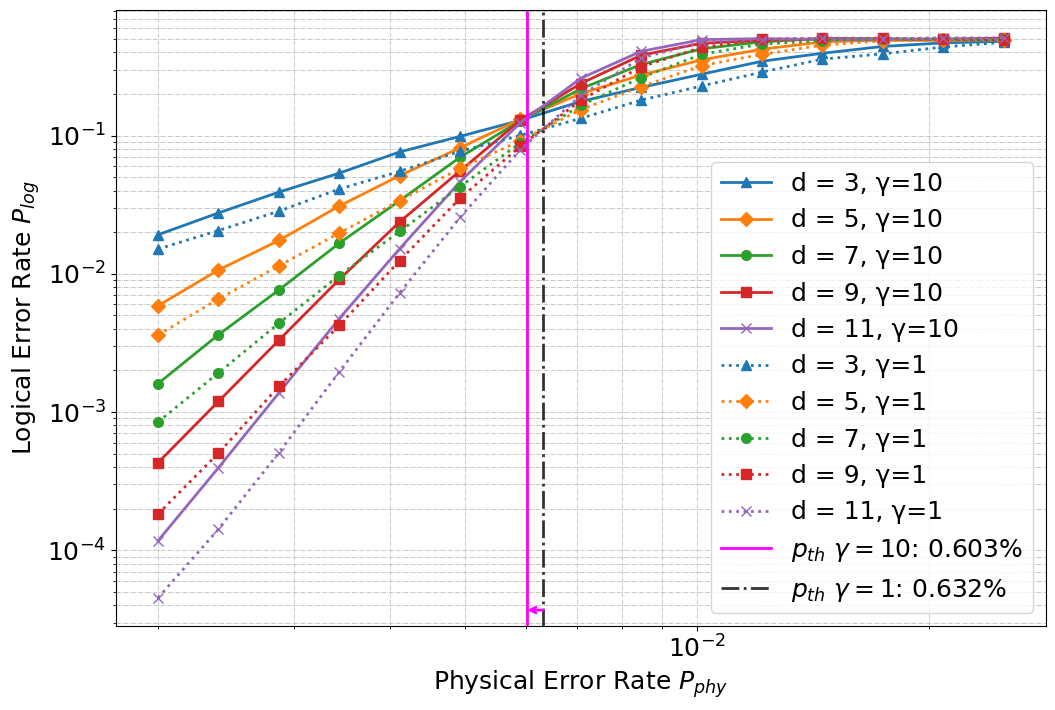

Generating plot for Function: unrotated_CAT, Direction: Vertical
Found intersection between d=3 and d=5: 0.006367707306880867
Found intersection between d=5 and d=7: 0.006234386841523895
Found intersection between d=7 and d=9: 0.006204428267893685
Found intersection between d=9 and d=11: 0.006295837523580028


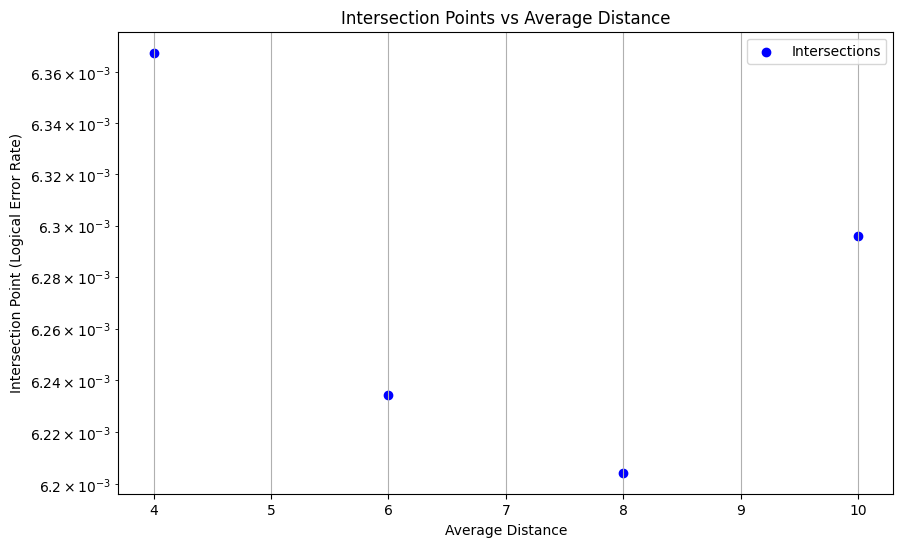

Average of valid intersections: 0.006275589984969619
Threshold p for set1 (unrotated_CAT γ=10): 0.006276
Found intersection between d=3 and d=5: 0.006460883311329867
Found intersection between d=5 and d=7: 0.006372780356586059
Found intersection between d=7 and d=9: 0.006327468712866007
Found intersection between d=9 and d=11: 0.006421237135257276


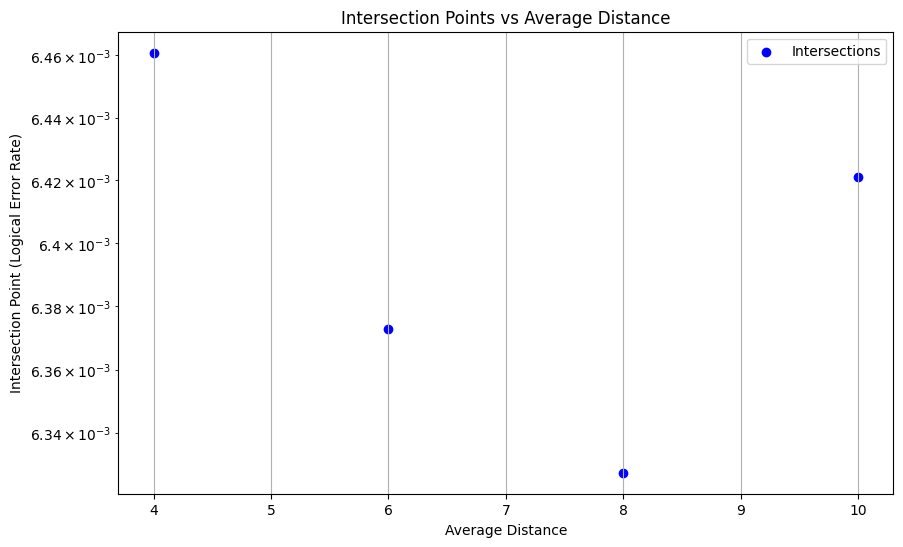

Average of valid intersections: 0.006395592379009801
Threshold p for set2 (unrotated_CAT γ=1): 0.006396
Plot saved to [[27FEB]] - [[PDF]] FULL+IDLING- EXTRA DISTANCES\unrotated_CAT_Vertical_gamma10_gamma1.PDF


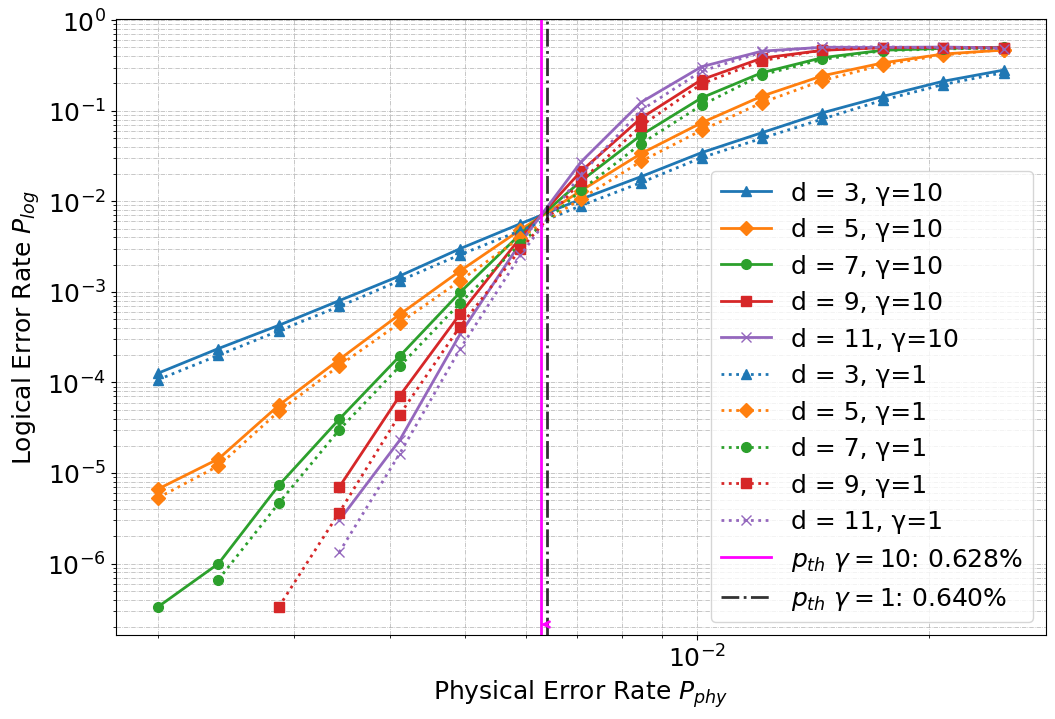

Generating plot for Function: unrotated_GT, Direction: Horizontal
Found intersection between d=3 and d=5: 0.00519292783747469
Found intersection between d=5 and d=7: 0.006138692090937829
Found intersection between d=7 and d=9: 0.005551133734089359
Found intersection between d=9 and d=11: 0.006023698431079322


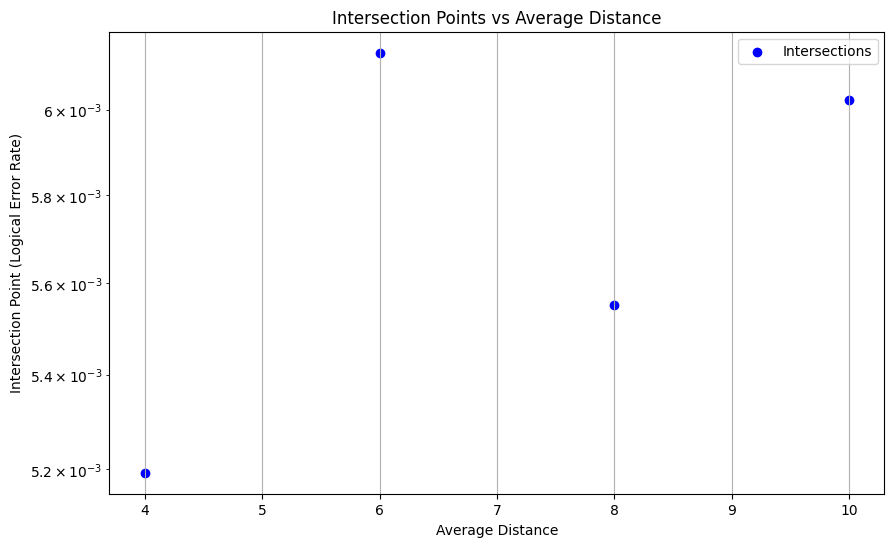

Average of valid intersections: 0.0057266130233953
Threshold p for set1 (unrotated_GT γ=10): 0.005727
Found intersection between d=3 and d=5: 0.005829854608498647
Found intersection between d=5 and d=7: 0.006599800570907261
Found intersection between d=7 and d=9: 0.005811521138333909
Found intersection between d=9 and d=11: 0.006339985099459603


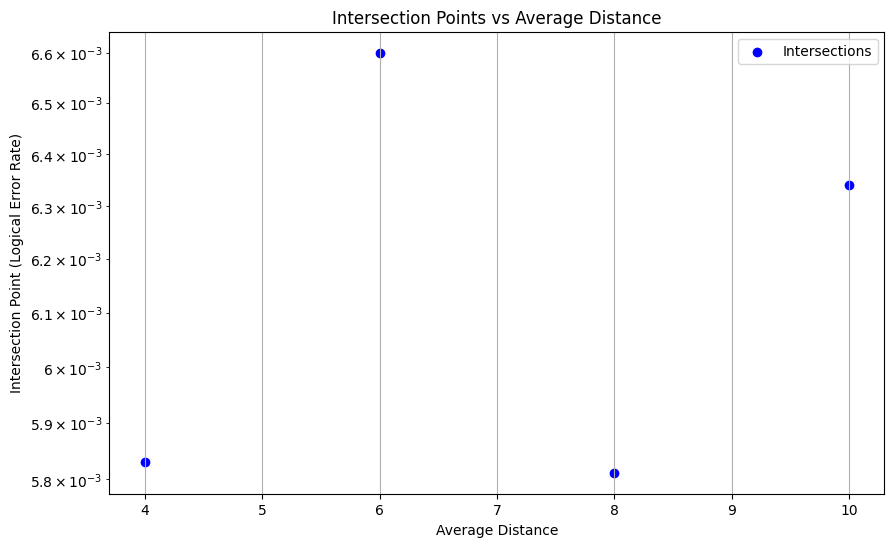

Average of valid intersections: 0.006145290354299855
Threshold p for set2 (unrotated_GT γ=1): 0.006145
Plot saved to [[27FEB]] - [[PDF]] FULL+IDLING- EXTRA DISTANCES\unrotated_GT_Horizontal_gamma10_gamma1.PDF


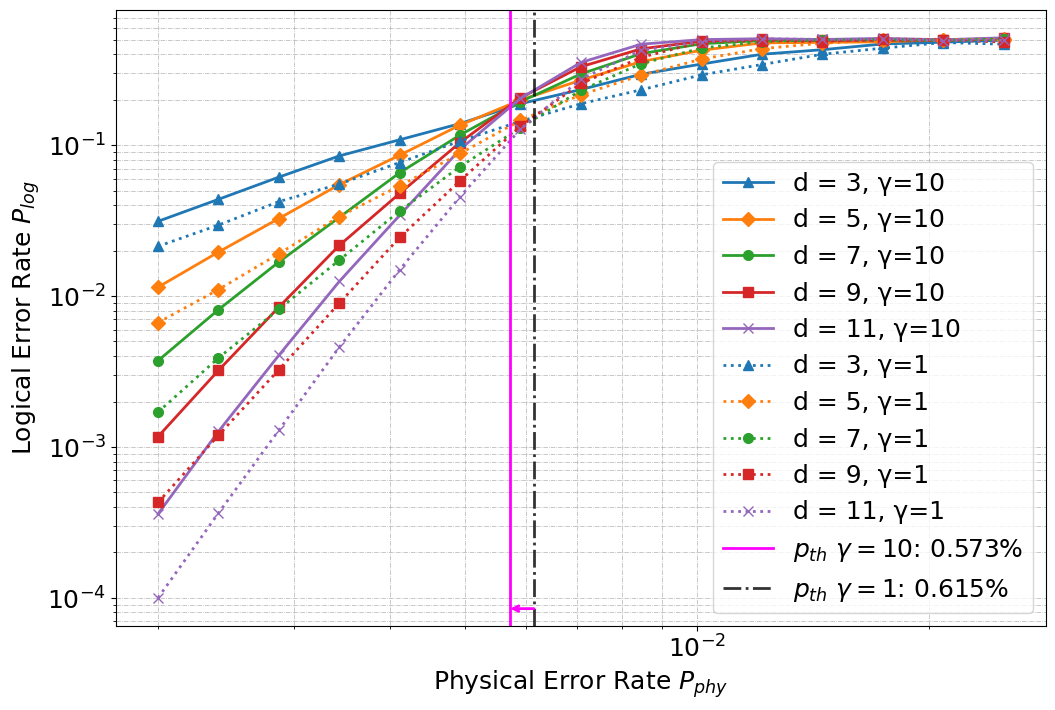

Generating plot for Function: unrotated_GT, Direction: Vertical
Found intersection between d=3 and d=5: 0.006875382466780661
Found intersection between d=5 and d=7: 0.006403744066601374
Found intersection between d=7 and d=9: 0.006377285128352494
Found intersection between d=9 and d=11: 0.006305782347394214


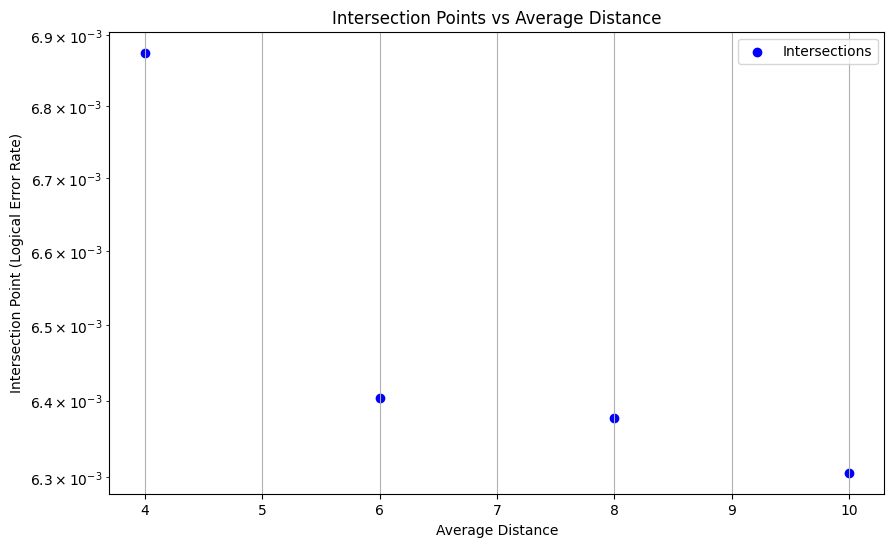

Average of valid intersections: 0.006490548502282186
Threshold p for set1 (unrotated_GT γ=10): 0.006491
Found intersection between d=3 and d=5: 0.007059840845579592
Found intersection between d=5 and d=7: 0.00662037619015032
Found intersection between d=7 and d=9: 0.006449969053590648
Found intersection between d=9 and d=11: 0.006464975058493783


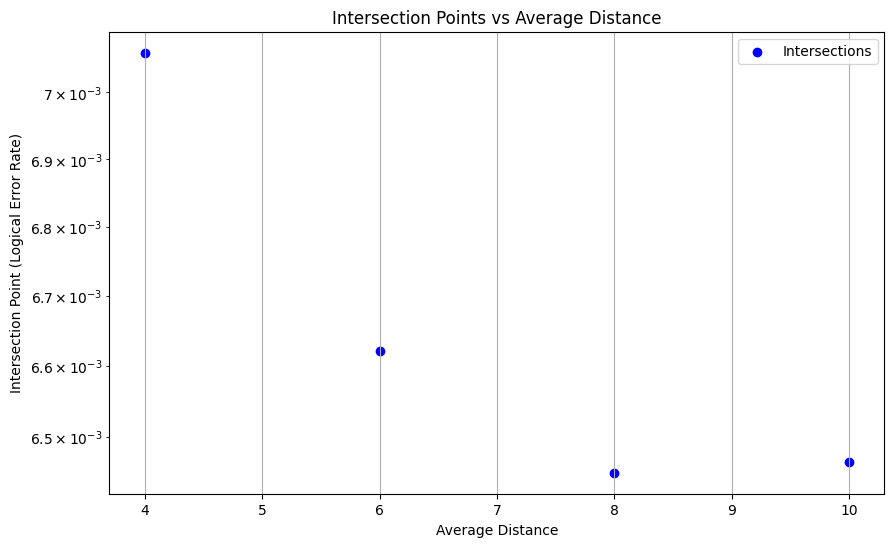

Average of valid intersections: 0.006648790286953586
Threshold p for set2 (unrotated_GT γ=1): 0.006649
Plot saved to [[27FEB]] - [[PDF]] FULL+IDLING- EXTRA DISTANCES\unrotated_GT_Vertical_gamma10_gamma1.PDF


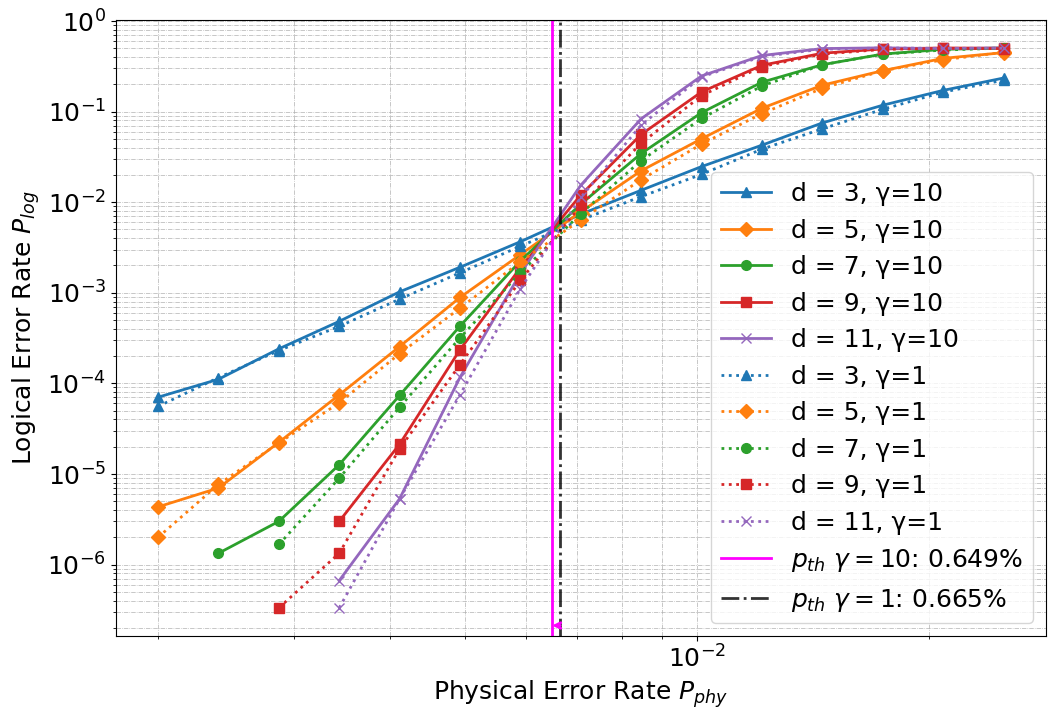

Thresholds summary:
            Function   Direction  Multiplier1  Threshold1  Multiplier2  \
0        Rotated_CAT  Horizontal           10    0.005714            1   
1        Rotated_CAT    Vertical           10    0.006494            1   
2     Rotated_Direct  Horizontal           10    0.006308            1   
3     Rotated_Direct    Vertical           10    0.007800            1   
4         Rotated_GT  Horizontal           10    0.005472            1   
5         Rotated_GT    Vertical           10    0.006411            1   
6   Unrotated_Direct  Horizontal           10    0.007317            1   
7   Unrotated_Direct    Vertical           10    0.007676            1   
8      unrotated_CAT  Horizontal           10    0.006026            1   
9      unrotated_CAT    Vertical           10    0.006276            1   
10      unrotated_GT  Horizontal           10    0.005727            1   
11      unrotated_GT    Vertical           10    0.006491            1   

    Threshold2  


In [ ]:
import os
import pandas as pd

# Define the list of function names and directions
function_names = ["Rotated_CAT", "Rotated_Direct", "Rotated_GT", "Unrotated_Direct", "unrotated_CAT", "unrotated_GT"]
directions = ["Horizontal", "Vertical"]

# Define the multipliers
multiplier1 = 10
multiplier2 = 1

# Define the folder to save plots
save_folder = "Results"
os.makedirs(save_folder, exist_ok=True)

# List to accumulate thresholds information
thresholds_list = []

# Loop through each function name and direction
for func in function_names:
    for dir in directions:
        # Define the save path with a clear naming convention
        save_filename = f"{func}_{dir}_gamma{multiplier1}_gamma{multiplier2}.PDF"
        save_path = os.path.join(save_folder, save_filename)
        
        # Print status
        print(f"Generating plot for Function: {func}, Direction: {dir}")
        
        # Plot both multipliers on the same graph and capture the thresholds.
        p_threshold1, p_threshold2 = plot_two_simulation_results(
            results_dict,
            function_name1=func,
            direction1=dir,
            multiplier1=multiplier1,
            function_name2=func,
            direction2=dir,
            multiplier2=multiplier2,
            save_path=save_path
        )
        
        # Append collected data to the thresholds list
        thresholds_list.append({
            'Function': func,
            'Direction': dir,
            'Multiplier1': multiplier1,
            'Threshold1': p_threshold1,
            'Multiplier2': multiplier2,
            'Threshold2': p_threshold2
        })

# Convert the thresholds list to a DataFrame for easy viewing or exporting
df_thresholds = pd.DataFrame(thresholds_list)
print("Thresholds summary:")
print(df_thresholds)

# Optionally, save the thresholds table to a CSV file
df_thresholds.to_csv("thresholds_summary.csv", index=False)
print("Thresholds summary saved to thresholds_summary.csv")